# Tennis Match Prediction with Optuna

## Match parameters

✅ Données d’entrée nécessaires
Voici les caractéristiques essentielles (features) à fournir pour chaque match :

|Variable|	Type|	Description|
| --- | --- | --- |
|Rank_1|	int|	Classement ATP de Player_1|
|Rank_2|	int|	Classement ATP de Player_2|
|Pts_1|	int|	Points ATP de Player_1|
|Pts_2|	int|	Points ATP de Player_2|
|Odd_1|	float|	Cote pré-match de Player_1 (optionnelle mais utile)|
|Odd_2|	float|	Cote pré-match de Player_2|
|Surface|	str|	Surface du match (Hard, Clay, Grass)|
|Round|	str|	Tour du match (1st Round, Quarterfinal, etc.)|
|Best of|	int|	Nombre de sets gagnants (3 ou 5)|
|Court|	str|	Indoor / Outdoor|

In [1]:
exemple_match = {
    "Rank_1": 15,
    "Rank_2": 441,
    "Pts_1": 2745,
    "Pts_2": 105,
    "Odd_1": 1.10,
    "Odd_2": 6.75,
    "Surface": "Hard",
    "Round": "2nd Round",
    "Best of": 3,
    "Court": "Outdoor"
}

## Install librairies

In [2]:
pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Data Acquisition

In [3]:
import csv
from datetime import datetime, timedelta

def parse_date_flexible(date_str):
    """Essaie plusieurs formats de date."""
    for fmt in ('%Y-%m-%d %H:%M:%S', '%Y-%m-%d', '%d/%m/%Y %H:%M', '%d/%m/%Y'):
        try:
            return datetime.strptime(date_str.strip(), fmt)
        except ValueError:
            continue
    return None

def filtrer_et_normaliser_matchs(fichier_entree, fichier_sortie):
    maintenant = datetime.now()
    trois_mois = timedelta(days=90)
    matchs_conserves = 0

    with open(fichier_entree, mode='r', encoding='utf-8') as infile, \
         open(fichier_sortie, mode='w', newline='', encoding='utf-8') as outfile:
        
        lecteur = csv.DictReader(infile, delimiter=',')
        champs = lecteur.fieldnames
        ecrivain = csv.DictWriter(outfile, fieldnames=champs, delimiter=',')
        ecrivain.writeheader()

        for ligne in lecteur:
            date_str = ligne.get('Date', '')
            date_match = parse_date_flexible(date_str)
            if date_match and (maintenant - date_match <= trois_mois):
                # Normalisation de la date
                ligne['Date'] = date_match.strftime('%Y-%m-%d %H:%M:%S')
                ecrivain.writerow(ligne)
                matchs_conserves += 1

    print(f"{matchs_conserves} matchs conservés (joués dans les 3 derniers mois).")


# Extraction des matchs ATP des 3 derniers mois
filtrer_et_normaliser_matchs('../data/atp_tennis.csv', '../data/matches_atp_3_derniers_mois.csv')

# Extraction des matchs WTA des 3 derniers mois
filtrer_et_normaliser_matchs('../data/wta.csv', '../data/matches_wta_3_derniers_mois.csv')


615 matchs conservés (joués dans les 3 derniers mois).
619 matchs conservés (joués dans les 3 derniers mois).


#### Custom Data Extraction Functions

#### Applying Functions

## Machine Learning

### Import des librairies et chargement des données

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import joblib

### 1. Chargement des données
df = pd.read_csv("../data/matches_atp_3_derniers_mois.csv")


### Ajout de données dans le df

In [5]:
import re

def count_total_games(score_str):
    if pd.isna(score_str):
        return None
    sets = re.findall(r'(\d+)-(\d+)', score_str)
    total_games = sum(int(a) + int(b) for a, b in sets)
    return total_games

df['Total_Games'] = df['Score'].apply(count_total_games)
df = df.dropna(subset=['Total_Games'])  # utile pour la régression

### Nettoyage & définition des colonnes

In [6]:

### 2. Nettoyage

df = df.dropna(subset=[
    'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
    'Odd_1', 'Odd_2', 'Surface', 'Round', 'Best of', 'Court'
])
df['Winner_encoded'] = (df['Winner'] == df['Player_1']).astype(int)

### 3. Définition des colonnes

numeric_features = ['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2', 'Best of']
categorical_features = ['Surface', 'Round', 'Court']
all_features = numeric_features + categorical_features

X = df[all_features]
y = df['Winner_encoded']

### Split, Preprocessing & Modèles

In [7]:
### 4. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### 6. Modèles
models = {
    "LogisticRegression": (
        Pipeline([("preprocessor", preprocessor),
                  ("clf", LogisticRegression(max_iter=1000))]),
        {"clf__C": [0.01, 0.1, 1, 10]}
    ),
    "DecisionTree": (
        Pipeline([("preprocessor", preprocessor),
                  ("clf", DecisionTreeClassifier(random_state=42))]),
        {"clf__max_depth": [3, 5, 10], "clf__min_samples_split": [2, 5, 10]}
    ),
    "SVM": (
        Pipeline([("preprocessor", preprocessor),
                  ("clf", SVC(probability=True))]),
        {"clf__C": [0.1, 1, 10], "clf__kernel": ['linear', 'rbf']}
    ),
    "RandomForest": (
        Pipeline([("preprocessor", preprocessor),
                  ("clf", RandomForestClassifier(random_state=42))]),
        {"clf__n_estimators": [50, 100], "clf__max_depth": [5, 10, None]}
    )
}

### Entraînement + évaluation & Sauvegarde du modèle

In [8]:
### 7. Entraînement + évaluation
results = []
best_global_model = None
best_global_score = 0

for name, (model, params) in models.items():
    print(f"\n🔍 Training {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"✅ Best Params: {grid.best_params_}")
    print(f"📊 Accuracy: {acc:.3f}")
    print(f"📈 ROC AUC: {auc:.3f}")

    results.append({
        "Modèle": name,
        "Accuracy": acc,
        "ROC AUC": auc,
        "Best Params": grid.best_params_
    })

    if auc > best_global_score:
        best_global_model = best_model
        best_global_score = auc

### 8. Sauvegarde du meilleur modèle
joblib.dump(best_global_model, "../models/tennis_win_predictor.pkl")


🔍 Training LogisticRegression...
✅ Best Params: {'clf__C': 0.1}
📊 Accuracy: 0.699
📈 ROC AUC: 0.789

🔍 Training DecisionTree...
✅ Best Params: {'clf__max_depth': 3, 'clf__min_samples_split': 2}
📊 Accuracy: 0.642
📈 ROC AUC: 0.763

🔍 Training SVM...
✅ Best Params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
📊 Accuracy: 0.699
📈 ROC AUC: 0.789

🔍 Training RandomForest...
✅ Best Params: {'clf__max_depth': 5, 'clf__n_estimators': 100}
📊 Accuracy: 0.675
📈 ROC AUC: 0.752


['../models/tennis_win_predictor.pkl']

### Résumé et visualisation


📊 Résultats comparatifs :
               Modèle  Accuracy   ROC AUC  \
0  LogisticRegression  0.699187  0.789305   
2                 SVM  0.699187  0.788503   
1        DecisionTree  0.642276  0.763369   
3        RandomForest  0.674797  0.751604   

                                         Best Params  
0                                    {'clf__C': 0.1}  
2           {'clf__C': 0.1, 'clf__kernel': 'linear'}  
1  {'clf__max_depth': 3, 'clf__min_samples_split'...  
3    {'clf__max_depth': 5, 'clf__n_estimators': 100}  


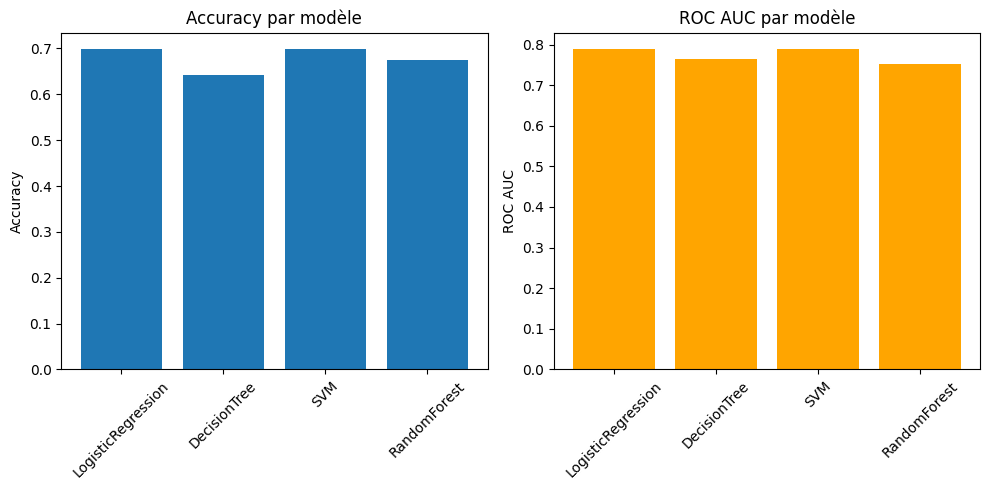

In [9]:
### 9. Résumé & visualisation
results_df = pd.DataFrame(results)
print("\n📊 Résultats comparatifs :")
print(results_df.sort_values(by="ROC AUC", ascending=False))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(results_df["Modèle"], results_df["Accuracy"])
plt.title("Accuracy par modèle")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(results_df["Modèle"], results_df["ROC AUC"], color='orange')
plt.title("ROC AUC par modèle")
plt.ylabel("ROC AUC")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Entraine uin modèle de régression pour le nombre de jeux du match

In [10]:
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

# 📌 On suppose que df['Total_Games'] est déjà calculé
X_games = df[all_features]  # mêmes features que pour la classification
y_games = df['Total_Games']

Xg_train, Xg_test, yg_train, yg_test = train_test_split(X_games, y_games, test_size=0.2, random_state=42)

# 📦 Modèles à tester
regression_models = {
    "RandomForest": Pipeline([
        ("preprocessor", preprocessor),
        ("reg", RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42))
    ]),
    "HistGradientBoosting": Pipeline([
        ("preprocessor", preprocessor),
        ("reg", HistGradientBoostingRegressor(max_iter=100, max_depth=10, random_state=42))
    ]),
    "LinearRegression": Pipeline([
        ("preprocessor", preprocessor),
        ("reg", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("preprocessor", preprocessor),
        ("reg", Ridge(alpha=1.0))
    ]),
    "MLP": Pipeline([
        ("preprocessor", preprocessor),
        ("reg", MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42))
    ])
}

# 🔍 Évaluation des modèles
regression_results = []

print("\n📈 Évaluation des modèles de régression (total de jeux) :\n")

for name, model in regression_models.items():
    model.fit(Xg_train, yg_train)
    yg_pred = model.predict(Xg_test)

    mse = mean_squared_error(yg_test, yg_pred)
    mae = mean_absolute_error(yg_test, yg_pred)
    r2 = r2_score(yg_test, yg_pred)

    print(f"🔹 {name}")
    print(f"  🔸 MSE  : {mse:.2f}")
    print(f"  🔸 MAE  : {mae:.2f}")
    print(f"  🔸 R²   : {r2:.3f}\n")

    regression_results.append({
        "Modèle": name,
        "MSE": mse,
        "MAE": mae,
        "R2": r2
    })

# 🔁 Sauvegarde du meilleur modèle de régression
best_reg_model_name = max(regression_results, key=lambda x: x["R2"])["Modèle"]
best_reg_model = regression_models[best_reg_model_name]

print(f"💾 Sauvegarde du meilleur modèle de régression : {best_reg_model_name}")
joblib.dump(best_reg_model, "../models/tennis_total_games_predictor.pkl")




📈 Évaluation des modèles de régression (total de jeux) :

🔹 RandomForest
  🔸 MSE  : 48.71
  🔸 MAE  : 5.72
  🔸 R²   : 0.237



c:\Users\N.ORLEY\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\N.ORLEY\AppData\Local\Programs\Python\Python39\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


🔹 HistGradientBoosting
  🔸 MSE  : 50.17
  🔸 MAE  : 5.68
  🔸 R²   : 0.215

🔹 LinearRegression
  🔸 MSE  : 39.81
  🔸 MAE  : 5.26
  🔸 R²   : 0.377

🔹 Ridge
  🔸 MSE  : 39.86
  🔸 MAE  : 5.26
  🔸 R²   : 0.376

🔹 MLP
  🔸 MSE  : 44.56
  🔸 MAE  : 5.50
  🔸 R²   : 0.302

💾 Sauvegarde du meilleur modèle de régression : LinearRegression


c:\Users\N.ORLEY\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


['../models/tennis_total_games_predictor.pkl']

### 🔮 Fonctions de prédiction

In [11]:
### 10. 🔮 Prédiction sur un match à partir d’un dictionnaire
def predict_match_proba(input_dict, model_path="../models/tennis_win_predictor.pkl"):
    model = joblib.load(model_path)
    X_input = pd.DataFrame([input_dict])
    prob = model.predict_proba(X_input)[0]
    return {
        "Probabilité victoire Player_1": round(prob[1], 4),
        "Probabilité victoire Player_2": round(prob[0], 4)
    }

### 10. 🔮 Prédiction du nombre de jeux
def predict_total_games(input_dict, model_path="../models/tennis_total_games_predictor.pkl"):
    model = joblib.load(model_path)
    X_input = pd.DataFrame([input_dict])
    return round(model.predict(X_input)[0])


### Hyperparameters Tuning avec Optuna

In [12]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingRegressor

# ⚠️ Utilise les mêmes features + preprocessor que précédemment
from sklearn.pipeline import Pipeline

# 🔁 Définir l'objective function pour Optuna pour le nombre de jeux
def objective_regression(trial):
    params = {
        "max_iter": trial.suggest_int("max_iter", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "l2_regularization": trial.suggest_float("l2_regularization", 1e-4, 1.0, log=True)
    }

    model = Pipeline([
        ("preprocessor", preprocessor),
        ("reg", HistGradientBoostingRegressor(random_state=42, **params))
    ])

    score = cross_val_score(model, Xg_train, yg_train, cv=5, scoring='r2').mean()
    return score


print("\n🎯 Lancement de l'optimisation Optuna pour la régression...")
study = optuna.create_study(direction="maximize")
study.optimize(objective_regression, n_trials=30)

print("✅ Meilleur score R² (cross-val):", study.best_value)
print("🏆 Meilleurs hyperparamètres :", study.best_params)



# 🔁 Définir l'objective function pour Optuna
def objective(trial):
    # Hyperparamètres à tester
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 30)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)
    
    # Pipeline complet avec preprocessor
    model = Pipeline([
        ("preprocessor", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # Evaluer ROC AUC et Accuracy
    roc_auc = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()
    accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    
    # Tu peux prioriser une métrique ou faire une moyenne pondérée
    score = (roc_auc + accuracy) / 2
    return score

# 🎯 Lancer l'optimisation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

# 🏆 Affichage des meilleurs hyperparamètres
print("✅ Best trial:")
print(f"  Value (score combiné) : {study.best_value:.4f}")
print(f"  Params : {study.best_params}")


[I 2025-03-21 16:58:19,057] A new study created in memory with name: no-name-fa158088-0b07-4960-98f7-5c6c8577e0a1



🎯 Lancement de l'optimisation Optuna pour la régression...


[I 2025-03-21 16:58:23,794] Trial 0 finished with value: 0.30720146759285333 and parameters: {'max_iter': 841, 'max_depth': 14, 'learning_rate': 0.05013567353551249, 'l2_regularization': 0.00030359140826772684}. Best is trial 0 with value: 0.30720146759285333.
[I 2025-03-21 16:58:24,573] Trial 1 finished with value: 0.4226479805951004 and parameters: {'max_iter': 165, 'max_depth': 7, 'learning_rate': 0.044123540760168264, 'l2_regularization': 0.0009700954368270876}. Best is trial 1 with value: 0.4226479805951004.
[I 2025-03-21 16:58:26,006] Trial 2 finished with value: 0.29879089421813354 and parameters: {'max_iter': 252, 'max_depth': 18, 'learning_rate': 0.18953403717049266, 'l2_regularization': 0.8644517343675545}. Best is trial 1 with value: 0.4226479805951004.
[I 2025-03-21 16:58:27,206] Trial 3 finished with value: 0.46040585753887653 and parameters: {'max_iter': 329, 'max_depth': 3, 'learning_rate': 0.010955614828875833, 'l2_regularization': 0.0019445950474776509}. Best is trial 

✅ Meilleur score R² (cross-val): 0.4607609971269957
🏆 Meilleurs hyperparamètres : {'max_iter': 366, 'max_depth': 3, 'learning_rate': 0.010349523844108338, 'l2_regularization': 0.00010447656932113442}


[I 2025-03-21 16:59:25,290] Trial 0 finished with value: 0.670837130306668 and parameters: {'n_estimators': 185, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.670837130306668.
[I 2025-03-21 16:59:26,390] Trial 1 finished with value: 0.6490394900384397 and parameters: {'n_estimators': 122, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.670837130306668.
[I 2025-03-21 16:59:28,058] Trial 2 finished with value: 0.6708066378066377 and parameters: {'n_estimators': 217, 'max_depth': 26, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.670837130306668.
[I 2025-03-21 16:59:29,507] Trial 3 finished with value: 0.6619135563316236 and parameters: {'n_estimators': 168, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.670837130306668.
[I 2025-03-21 16:59:30,375] Trial 4 finished with value: 0.6420038447197062 and parameters: {'n_

✅ Best trial:
  Value (score combiné) : 0.6796
  Params : {'n_estimators': 276, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 4}


### Réentrainement du modèle avec les meilleurs paramètres

In [ ]:
best_params = study.best_params

final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(
        **best_params,
        random_state=42,
        n_jobs=-1
    ))
])

final_model.fit(X_train, y_train)
joblib.dump(final_model, "../models/tennis_win_predictor_optuna.pkl")


# Meilleurs paramètres
best_params = study.best_params
print("🧩 best_params retournés par Optuna :", best_params)

# ⚠️ Supprimer toute clé non utilisée par HistGradientBoostingRegressor
accepted_params = ['max_iter', 'max_depth', 'learning_rate', 'l2_regularization']
filtered_params = {k: v for k, v in best_params.items() if k in accepted_params}

# Pipeline final
best_reg_model = Pipeline([
    ("preprocessor", preprocessor),
    ("reg", HistGradientBoostingRegressor(
        random_state=42,
        **filtered_params
    ))
])

# Entraînement
best_reg_model.fit(Xg_train, yg_train)

# Sauvegarde
joblib.dump(best_reg_model, "../models/tennis_total_games_predictor_optuna.pkl")


TypeError: __init__() got an unexpected keyword argument 'n_estimators'

## Prédiction avec modèle optimisé

In [ ]:
## 11. Exemple avec features supplémentaires

#probas = predict_match_proba(exemple_match)
#print("\n🎯 Prédiction du match :")
#for k, v in probas.items():
#    print(f"{k} : {v:.2%}")

probas = predict_match_proba(exemple_match, model_path="../models/tennis_win_predictor_optuna.pkl")
#print("\n🎯 Prédiction du match avec modèle optimisé :")
#for k, v in probas.items():
#    print(f"{k} : {v:.2%}")


# 🔢 Prédiction total jeux
#total_games = predict_total_games(exemple_match)
total_games = predict_total_games(exemple_match, model_path="../models/tennis_total_games_predictor_optuna.pkl")

print("\n🎯 Prédiction complète :")
for joueur, proba in probas.items():
    print(f"{joueur} : {proba:.2%}")
print(f"🧮 Nombre total de jeux estimé : {total_games}")